# Hyperparameter Optimization

In [2]:
import sys
import os
sys.path.append(os.getcwd())
sys.path.append(os.getcwd() + '/RoBO-master')

from robo.fmin import bayesian_optimization

import pickle
import numpy as np
import random
from operator import add
from copy import deepcopy
import matplotlib.pyplot as plt


rf = pickle.load(open("./rf_surrogate_cnn.pkl", "rb"))
cost_rf = pickle.load(open("./rf_cost_surrogate_cnn.pkl", "rb"))


def objective_function(x, epoch=40):
    """
        Function wrapper to approximate the validation error of the hyperparameter configurations x by the prediction of a surrogate regression model,
        which was trained on the validation error of randomly sampled hyperparameter configurations.
        The original surrogate predicts the validation error after a given epoch. Since all hyperparameter configurations were trained for a total amount of 
        40 epochs, we will query the performance after epoch 40.
    """
    
    # Normalize all hyperparameters to be in [0, 1]
    x_norm = deepcopy(x)
    x_norm[0] = (x[0] - (-6)) / (0 - (-6))
    x_norm[1] = (x[1] - 32) / (512 - 32)
    x_norm[2] = (x[2] - 4) / (10 - 4)
    x_norm[3] = (x[3] - 4) / (10 - 4)
    x_norm[4] = (x[4] - 4) / (10 - 4)
    

    x_norm = np.append(x_norm, epoch)
    y = rf.predict(x_norm[None, :])[0]

    return y

def runtime(x, epoch=40):
    """
        Function wrapper to approximate the runtime of the hyperparameter configurations x.
    """
    
    # Normalize all hyperparameter to be in [0, 1]
    x_norm = deepcopy(x)
    x_norm[0] = (x[0] - (-6)) / (0 - (-6))
    x_norm[1] = (x[1] - 32) / (512 - 32)
    x_norm[2] = (x[2] - 4) / (10 - 4)
    x_norm[3] = (x[3] - 4) / (10 - 4)
    x_norm[4] = (x[4] - 4) / (10 - 4)
    

    x_norm = np.append(x_norm, epoch)
    y = cost_rf.predict(x_norm[None, :])[0]

    return y

C:\Users\Kai\Anaconda3\lib\site-packages\sklearn\base.py:311: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.18.1 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\Kai\Anaconda3\lib\site-packages\sklearn\base.py:311: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.18.1 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [ ]:
def getRandomHyperparameters():
    """ Function to give some random hyperparameters in the correct interval as a 5 tuple.
    """
    learning_rate = random.uniform(-6, 0)
    batch_size = random.randint(32, 512)
    filters_1 = random.randint(4, 10)
    filters_2 = random.randint(4, 10)
    filters_3 = random.randint(4, 10)
    return [learning_rate, batch_size, filters_1, filters_2, filters_3]

In [3]:
def randomSearch(iterations):
    """ Performs random search and returns the performance after each iteration as a list. """
    incumbent = float("inf")
    performances = list()
    for iteration in range(iterations):
        hyperparameters = getRandomHyperparameters()
        objective_function_value = objective_function(hyperparameters)
        if objective_function_value < incumbent:
            incumbent = objective_function_value
        performances.append(incumbent)
    return performances

In [4]:
def testRandomSearch(iterations, tests):
    """ Give average incumbent development for test many learning curves.
    """
    result = randomSearch(iterations)
    for test in range(tests-1):
        result = map(add, result, randomSearch(iterations))
    return [el / tests for el in result]

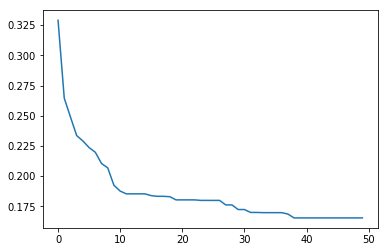

In [9]:
plt.plot(testRandomSearch(50, 10))
plt.savefig('incumbentRandom.png')
plt.show()

In [ ]:
plt.clf()
# Defining the bounds and dimensions of the input space
lower = np.array([-6, 32, 4, 4, 4])
upper = np.array([0, 512, 10, 10, 10])

# calculate cummulative runtime for bayes and random search.
results = bayesian_optimization(objective_function, lower, upper, num_iterations=50)
hyperparameters = results["X"]
runtime_bayes = [runtime[hyperparameter] for hyperparameter in hyperparameters]
runtime_bayes = np.cumsum(runtime_bayes)

runtime_random = [runtime(getRandomHyperparameters()) for _ in range(50)]
runtime_random = np.cumsum(runtime_random)


# plot cumultative runtime of bayesian optimization and random testing
plt.plot(runtime_bayes)
plt.plot(runtime_random)
plt.savefig("runtimes.png")
plt.show()

In [ ]:
plt.clf()
result = np.zeros(50)
# get average incumbent development
for _ in range(10):
    results = bayesian_optimization(objective_function, lower, upper, num_iterations=50)
    incumbents = results["incumbent_values"]
    result = np.add(result, incumbents)
result = np.divide(result, 10)
plt.plot(result)
plt.savefig("incumbentBayes.png")
plt.show()